# Comprehensive Benchmark: DID Estimators Comparison (Python)

Comparing Python implementations of difference-in-differences estimators:
- **pyfixest**: Sun-Abraham style event studies
- **differences**: Callaway-Sant'Anna ATT(g,t)
- **linearmodels**: Panel data models

Dataset: `wolfers2006_didtextbook.dta`

Specification: `did_multiplegt_dyn div_rate state year udl, effects(16) placebo(9) weight(stpop)`

In [1]:
# Install required packages if needed
import subprocess
import sys

packages = ['pandas', 'numpy', 'polars', 'pyreadstat', 'pyfixest', 'matplotlib', 'seaborn']

for package in packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])

Installing pyreadstat...


Installing pyfixest...


In [2]:
import pandas as pd
import numpy as np
import polars as pl
import pyreadstat
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("COMPREHENSIVE BENCHMARK: DID Estimators Comparison (Python)")
print("="*70)
print(f"Date: {datetime.now()}")
print(f"Packages: pyfixest, linearmodels, statsmodels")
print()

COMPREHENSIVE BENCHMARK: DID Estimators Comparison (Python)
Date: 2026-02-02 19:24:13.589465
Packages: pyfixest, linearmodels, statsmodels



In [3]:
# Load the Wolfers data
data_path = '../_data/wolfers2006_didtextbook.dta'

print("Loading data...")
wolfers, meta = pyreadstat.read_dta(data_path)
print(f"Original data rows: {len(wolfers)}")
print(f"Columns: {list(wolfers.columns)}")
wolfers.head()

Loading data...
Original data rows: 1683
Columns: ['year', 'div_rate', 'stpop', 'rel_time1', 'rel_time2', 'rel_time3', 'rel_time4', 'rel_time5', 'rel_time6', 'rel_time7', 'rel_time8', 'rel_time9', 'rel_time10', 'rel_time11', 'rel_time12', 'rel_time13', 'rel_time14', 'rel_time15', 'rel_time16', 'rel_timeminus1', 'rel_timeminus2', 'rel_timeminus3', 'rel_timeminus4', 'rel_timeminus5', 'rel_timeminus6', 'rel_timeminus7', 'rel_timeminus8', 'rel_timeminus9', 'state', 'cohort', 'controlgroup', 'early_late_never', 'udl', 'exposurelength', 'stpop1968']


,year,div_rate,stpop,rel_time1,rel_time2,rel_time3,rel_time4,rel_time5,rel_time6,rel_time7,...,rel_timeminus7,rel_timeminus8,rel_timeminus9,state,cohort,controlgroup,early_late_never,udl,exposurelength,stpop1968
0,1956.0,2.7,224000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1956.0,0.0,NaN,1.0,1.0,285000.0
1,1957.0,2.4,231000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1956.0,0.0,NaN,1.0,2.0,285000.0
2,1958.0,2.5,224000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1956.0,0.0,NaN,1.0,3.0,285000.0
3,1959.0,3.0,224000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1956.0,0.0,NaN,1.0,4.0,285000.0
4,1960.0,3.5,229000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1956.0,0.0,NaN,1.0,5.0,285000.0


In [4]:
# Prepare data - create first treatment time variable for CS/SA estimators
def prepare_data(df):
    """Add first_treat variable for Callaway-Sant'Anna / Sun-Abraham estimators"""
    df = df.copy()
    
    # Create first treatment time
    def get_first_treat(group):
        treated_years = group.loc[group['udl'] == 1, 'year']
        if len(treated_years) > 0:
            return treated_years.min()
        return 0
    
    first_treat_map = df.groupby('state').apply(get_first_treat)
    df['first_treat'] = df['state'].map(first_treat_map)
    
    # Create relative time variable
    df['rel_time'] = np.where(df['first_treat'] == 0, -1000, 
                               df['year'] - df['first_treat'])
    
    return df

wolfers = prepare_data(wolfers)

print(f"Unique states: {wolfers['state'].nunique()}")
print(f"Year range: {wolfers['year'].min()} - {wolfers['year'].max()}")
print(f"Treatment groups (first_treat): {sorted(wolfers['first_treat'].unique())}")

Unique states: 51
Year range: 1956.0 - 1988.0
Treatment groups (first_treat): [np.float64(0.0), np.float64(1956.0), np.float64(1969.0), np.float64(1970.0), np.float64(1971.0), np.float64(1972.0), np.float64(1973.0), np.float64(1974.0), np.float64(1975.0), np.float64(1976.0), np.float64(1977.0), np.float64(1985.0)]


In [5]:
# Helper functions
def run_with_timeout(func, timeout_sec=3600):
    """Run function with timing"""
    result = {'time': None, 'output': None, 'status': 'error'}
    
    try:
        start_time = time.time()
        result['output'] = func()
        end_time = time.time()
        result['time'] = end_time - start_time
        result['status'] = 'completed'
    except Exception as e:
        result['status'] = f'error: {str(e)[:100]}'
    
    return result

def create_synthetic_data(df, multiplier):
    """Create synthetic data by duplicating groups with new state IDs"""
    if multiplier == 1:
        return df.copy()
    
    max_state = df['state'].max()
    dfs = []
    
    for i in range(multiplier):
        temp_df = df.copy()
        temp_df['state'] = temp_df['state'] + i * max_state * 10
        dfs.append(temp_df)
    
    result = pd.concat(dfs, ignore_index=True)
    return result

# Store results
results = []

## Scenario 1: Original Data (~1,683 rows)

In [6]:
print("\n" + "="*70)
print(f"SCENARIO 1: Original Data ({len(wolfers)} rows)")
print("="*70 + "\n")


SCENARIO 1: Original Data (1683 rows)



In [7]:
# 1. pyfixest - Two-Way Fixed Effects
print("1. Running pyfixest (TWFE)...")

try:
    import pyfixest as pf
    
    def run_pyfixest_twfe():
        model = pf.feols(
            "div_rate ~ udl | state + year",
            data=wolfers,
            weights="stpop",
            vcov="hetero"
        )
        return model
    
    res_pf_twfe = run_with_timeout(run_pyfixest_twfe)
    print(f"   Time: {res_pf_twfe['time']:.2f} seconds" if res_pf_twfe['status'] == 'completed' else f"   Status: {res_pf_twfe['status']}")
    
    results.append({
        'scenario': 'Original (1.7K)',
        'package': 'pyfixest-TWFE',
        'rows': len(wolfers),
        'time_seconds': res_pf_twfe['time'],
        'status': res_pf_twfe['status']
    })
    
    if res_pf_twfe['status'] == 'completed':
        print(res_pf_twfe['output'].summary())
except Exception as e:
    print(f"   Error: {e}")
    results.append({
        'scenario': 'Original (1.7K)',
        'package': 'pyfixest-TWFE',
        'rows': len(wolfers),
        'time_seconds': None,
        'status': f'error: {str(e)[:100]}'
    })

1. Running pyfixest (TWFE)...


   Time: 2.18 seconds
###

Estimation:  OLS
Dep. var.: div_rate, Fixed effects: state+year
Inference:  hetero
Observations:  1631

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| udl           |     -0.055 |        0.058 |    -0.943 |      0.346 | -0.169 |   0.059 |
---
RMSE: 1031.449 R2: 0.93 R2 Within: 0.001 
None


In [8]:
# 2. pyfixest - Sun-Abraham Event Study
print("2. Running pyfixest (Sun-Abraham Event Study)...")

try:
    import pyfixest as pf
    
    # Prepare data for event study
    wolfers_es = wolfers.copy()
    # Filter to treated and never-treated units
    wolfers_es = wolfers_es[wolfers_es['first_treat'] != 0].copy()  # Keep only treated for event study
    
    def run_pyfixest_es():
        # Create event study with relative time indicators
        model = pf.feols(
            "div_rate ~ i(rel_time, ref=-1) | state + year",
            data=wolfers_es[(wolfers_es['rel_time'] >= -9) & (wolfers_es['rel_time'] <= 16)],
            weights="stpop",
            vcov="hetero"
        )
        return model
    
    res_pf_es = run_with_timeout(run_pyfixest_es)
    print(f"   Time: {res_pf_es['time']:.2f} seconds" if res_pf_es['status'] == 'completed' else f"   Status: {res_pf_es['status']}")
    
    results.append({
        'scenario': 'Original (1.7K)',
        'package': 'pyfixest-EventStudy',
        'rows': len(wolfers),
        'time_seconds': res_pf_es['time'],
        'status': res_pf_es['status']
    })
    
    if res_pf_es['status'] == 'completed':
        print(res_pf_es['output'].summary())
except Exception as e:
    print(f"   Error: {e}")
    results.append({
        'scenario': 'Original (1.7K)',
        'package': 'pyfixest-EventStudy',
        'rows': len(wolfers),
        'time_seconds': None,
        'status': f'error: {str(e)[:100]}'
    })

2. Running pyfixest (Sun-Abraham Event Study)...
   Time: 0.06 seconds
###

Estimation:  OLS
Dep. var.: div_rate, Fixed effects: state+year
Inference:  hetero
Observations:  731

| Coefficient                                   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:----------------------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| C(rel_time, contr.treatment(base=-1))[T.-9.0] |      0.213 |        0.198 |     1.079 |      0.281 | -0.175 |   0.601 |
| C(rel_time, contr.treatment(base=-1))[T.-8.0] |      0.126 |        0.161 |     0.785 |      0.433 | -0.189 |   0.442 |
| C(rel_time, contr.treatment(base=-1))[T.-7.0] |      0.035 |        0.149 |     0.237 |      0.813 | -0.258 |   0.329 |
| C(rel_time, contr.treatment(base=-1))[T.-6.0] |      0.000 |        0.143 |     0.002 |      0.998 | -0.281 |   0.282 |
| C(rel_time, contr.treatment(base=-1))[T.-5.0] |      0.039 |        0.141 |     0.275 |

In [9]:
# 3. linearmodels - Panel OLS with Fixed Effects
print("3. Running linearmodels (PanelOLS)...")

try:
    from linearmodels.panel import PanelOLS
    
    def run_linearmodels():
        # Prepare panel data
        panel_data = wolfers.set_index(['state', 'year'])
        
        model = PanelOLS(
            dependent=panel_data['div_rate'],
            exog=panel_data[['udl']],
            entity_effects=True,
            time_effects=True,
            weights=panel_data['stpop']
        )
        return model.fit(cov_type='robust')
    
    res_lm = run_with_timeout(run_linearmodels)
    print(f"   Time: {res_lm['time']:.2f} seconds" if res_lm['status'] == 'completed' else f"   Status: {res_lm['status']}")
    
    results.append({
        'scenario': 'Original (1.7K)',
        'package': 'linearmodels-PanelOLS',
        'rows': len(wolfers),
        'time_seconds': res_lm['time'],
        'status': res_lm['status']
    })
    
    if res_lm['status'] == 'completed':
        print(res_lm['output'].summary)
except ImportError:
    print("   linearmodels not installed. Installing...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'linearmodels', '-q'])
    print("   Please re-run this cell.")
except Exception as e:
    print(f"   Error: {e}")
    results.append({
        'scenario': 'Original (1.7K)',
        'package': 'linearmodels-PanelOLS',
        'rows': len(wolfers),
        'time_seconds': None,
        'status': f'error: {str(e)[:100]}'
    })

3. Running linearmodels (PanelOLS)...
   linearmodels not installed. Installing...


   Please re-run this cell.


In [10]:
# 4. statsmodels - OLS with dummies (baseline comparison)
print("4. Running statsmodels (OLS with dummies)...")

try:
    import statsmodels.api as sm
    from statsmodels.regression.linear_model import WLS
    
    def run_statsmodels():
        # Create dummies for state and year
        df = wolfers.copy()
        df = pd.get_dummies(df, columns=['state', 'year'], drop_first=True, dtype=float)
        
        # Get all columns except div_rate for X
        y = df['div_rate']
        x_cols = ['udl'] + [c for c in df.columns if c.startswith('state_') or c.startswith('year_')]
        X = sm.add_constant(df[x_cols])
        
        model = WLS(y, X, weights=wolfers['stpop'])
        return model.fit(cov_type='HC1')
    
    res_sm = run_with_timeout(run_statsmodels)
    print(f"   Time: {res_sm['time']:.2f} seconds" if res_sm['status'] == 'completed' else f"   Status: {res_sm['status']}")
    
    results.append({
        'scenario': 'Original (1.7K)',
        'package': 'statsmodels-WLS',
        'rows': len(wolfers),
        'time_seconds': res_sm['time'],
        'status': res_sm['status']
    })
    
    if res_sm['status'] == 'completed':
        # Only show udl coefficient
        print(f"\n   udl coefficient: {res_sm['output'].params['udl']:.6f}")
        print(f"   udl std error: {res_sm['output'].bse['udl']:.6f}")
        print(f"   udl p-value: {res_sm['output'].pvalues['udl']:.6f}")
except Exception as e:
    print(f"   Error: {e}")
    results.append({
        'scenario': 'Original (1.7K)',
        'package': 'statsmodels-WLS',
        'rows': len(wolfers),
        'time_seconds': None,
        'status': f'error: {str(e)[:100]}'
    })

4. Running statsmodels (OLS with dummies)...


   Time: 0.04 seconds

   udl coefficient: nan
   udl std error: nan
   udl p-value: nan


## Scenario 2: Synthetic Data 100x (~168,300 rows)

In [11]:
print("\n" + "="*70)
print("SCENARIO 2: Synthetic Data 100x")
print("="*70 + "\n")

wolfers_100x = create_synthetic_data(wolfers, 100)
print(f"Synthetic data rows: {len(wolfers_100x)}")


SCENARIO 2: Synthetic Data 100x

Synthetic data rows: 168300


In [12]:
# 1. pyfixest TWFE - 100x
print("1. Running pyfixest (TWFE) on 100x data...")

try:
    def run_pyfixest_100x():
        model = pf.feols(
            "div_rate ~ udl | state + year",
            data=wolfers_100x,
            weights="stpop",
            vcov="hetero"
        )
        return model
    
    res_pf_100x = run_with_timeout(run_pyfixest_100x)
    print(f"   Time: {res_pf_100x['time']:.2f} seconds" if res_pf_100x['status'] == 'completed' else f"   Status: {res_pf_100x['status']}")
    
    results.append({
        'scenario': '100x (168K)',
        'package': 'pyfixest-TWFE',
        'rows': len(wolfers_100x),
        'time_seconds': res_pf_100x['time'],
        'status': res_pf_100x['status']
    })
except Exception as e:
    print(f"   Error: {e}")

1. Running pyfixest (TWFE) on 100x data...


   Time: 0.16 seconds

In [13]:
# 2. pyfixest Event Study - 100x
print("2. Running pyfixest (Event Study) on 100x data...")

try:
    wolfers_100x_es = wolfers_100x[wolfers_100x['first_treat'] != 0].copy()
    
    def run_pyfixest_es_100x():
        model = pf.feols(
            "div_rate ~ i(rel_time, ref=-1) | state + year",
            data=wolfers_100x_es[(wolfers_100x_es['rel_time'] >= -9) & (wolfers_100x_es['rel_time'] <= 16)],
            weights="stpop",
            vcov="hetero"
        )
        return model
    
    res_pf_es_100x = run_with_timeout(run_pyfixest_es_100x)
    print(f"   Time: {res_pf_es_100x['time']:.2f} seconds" if res_pf_es_100x['status'] == 'completed' else f"   Status: {res_pf_es_100x['status']}")
    
    results.append({
        'scenario': '100x (168K)',
        'package': 'pyfixest-EventStudy',
        'rows': len(wolfers_100x),
        'time_seconds': res_pf_es_100x['time'],
        'status': res_pf_es_100x['status']
    })
except Exception as e:
    print(f"   Error: {e}")

2. Running pyfixest (Event Study) on 100x data...


   Time: 0.20 seconds


In [14]:
# 3. linearmodels - 100x
print("3. Running linearmodels (PanelOLS) on 100x data...")

try:
    from linearmodels.panel import PanelOLS
    
    def run_linearmodels_100x():
        panel_data = wolfers_100x.set_index(['state', 'year'])
        
        model = PanelOLS(
            dependent=panel_data['div_rate'],
            exog=panel_data[['udl']],
            entity_effects=True,
            time_effects=True,
            weights=panel_data['stpop']
        )
        return model.fit(cov_type='robust')
    
    res_lm_100x = run_with_timeout(run_linearmodels_100x)
    print(f"   Time: {res_lm_100x['time']:.2f} seconds" if res_lm_100x['status'] == 'completed' else f"   Status: {res_lm_100x['status']}")
    
    results.append({
        'scenario': '100x (168K)',
        'package': 'linearmodels-PanelOLS',
        'rows': len(wolfers_100x),
        'time_seconds': res_lm_100x['time'],
        'status': res_lm_100x['status']
    })
except Exception as e:
    print(f"   Error: {e}")

3. Running linearmodels (PanelOLS) on 100x data...


   Time: 0.66 seconds


In [15]:
# Clean up 100x data
del wolfers_100x
import gc
gc.collect()

64

## Scenario 3: Synthetic Data 1000x (~1,683,000 rows)

In [16]:
print("\n" + "="*70)
print("SCENARIO 3: Synthetic Data 1000x")
print("="*70 + "\n")

wolfers_1000x = create_synthetic_data(wolfers, 1000)
print(f"Synthetic data rows: {len(wolfers_1000x)}")


SCENARIO 3: Synthetic Data 1000x



Synthetic data rows: 1683000


In [17]:
# 1. pyfixest TWFE - 1000x
print("1. Running pyfixest (TWFE) on 1000x data...")

try:
    def run_pyfixest_1000x():
        model = pf.feols(
            "div_rate ~ udl | state + year",
            data=wolfers_1000x,
            weights="stpop",
            vcov="hetero"
        )
        return model
    
    res_pf_1000x = run_with_timeout(run_pyfixest_1000x)
    print(f"   Time: {res_pf_1000x['time']:.2f} seconds" if res_pf_1000x['status'] == 'completed' else f"   Status: {res_pf_1000x['status']}")
    
    results.append({
        'scenario': '1000x (1.68M)',
        'package': 'pyfixest-TWFE',
        'rows': len(wolfers_1000x),
        'time_seconds': res_pf_1000x['time'],
        'status': res_pf_1000x['status']
    })
except Exception as e:
    print(f"   Error: {e}")

1. Running pyfixest (TWFE) on 1000x data...


   Time: 0.83 seconds


In [18]:
# 2. pyfixest Event Study - 1000x
print("2. Running pyfixest (Event Study) on 1000x data...")

try:
    wolfers_1000x_es = wolfers_1000x[wolfers_1000x['first_treat'] != 0].copy()
    
    def run_pyfixest_es_1000x():
        model = pf.feols(
            "div_rate ~ i(rel_time, ref=-1) | state + year",
            data=wolfers_1000x_es[(wolfers_1000x_es['rel_time'] >= -9) & (wolfers_1000x_es['rel_time'] <= 16)],
            weights="stpop",
            vcov="hetero"
        )
        return model
    
    res_pf_es_1000x = run_with_timeout(run_pyfixest_es_1000x)
    print(f"   Time: {res_pf_es_1000x['time']:.2f} seconds" if res_pf_es_1000x['status'] == 'completed' else f"   Status: {res_pf_es_1000x['status']}")
    
    results.append({
        'scenario': '1000x (1.68M)',
        'package': 'pyfixest-EventStudy',
        'rows': len(wolfers_1000x),
        'time_seconds': res_pf_es_1000x['time'],
        'status': res_pf_es_1000x['status']
    })
except Exception as e:
    print(f"   Error: {e}")

2. Running pyfixest (Event Study) on 1000x data...


   Time: 0.79 seconds


In [19]:
# 3. linearmodels - 1000x (may be slow/memory intensive)
print("3. Running linearmodels (PanelOLS) on 1000x data...")

try:
    from linearmodels.panel import PanelOLS
    
    def run_linearmodels_1000x():
        panel_data = wolfers_1000x.set_index(['state', 'year'])
        
        model = PanelOLS(
            dependent=panel_data['div_rate'],
            exog=panel_data[['udl']],
            entity_effects=True,
            time_effects=True,
            weights=panel_data['stpop']
        )
        return model.fit(cov_type='robust')
    
    res_lm_1000x = run_with_timeout(run_linearmodels_1000x)
    print(f"   Time: {res_lm_1000x['time']:.2f} seconds" if res_lm_1000x['status'] == 'completed' else f"   Status: {res_lm_1000x['status']}")
    
    results.append({
        'scenario': '1000x (1.68M)',
        'package': 'linearmodels-PanelOLS',
        'rows': len(wolfers_1000x),
        'time_seconds': res_lm_1000x['time'],
        'status': res_lm_1000x['status']
    })
except Exception as e:
    print(f"   Error: {e}")

3. Running linearmodels (PanelOLS) on 1000x data...


   Time: 5.35 seconds


In [20]:
# Clean up 1000x data
del wolfers_1000x
gc.collect()

23

## Summary of Results

In [21]:
print("\n" + "="*70)
print("SUMMARY OF RESULTS")
print("="*70 + "\n")

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


SUMMARY OF RESULTS

       scenario               package    rows  time_seconds    status
Original (1.7K)         pyfixest-TWFE    1683      2.178139 completed
Original (1.7K)   pyfixest-EventStudy    1683      0.055938 completed
Original (1.7K)       statsmodels-WLS    1683      0.036629 completed
    100x (168K)         pyfixest-TWFE  168300      0.164769 completed
    100x (168K)   pyfixest-EventStudy  168300      0.202933 completed
    100x (168K) linearmodels-PanelOLS  168300      0.662254 completed
  1000x (1.68M)         pyfixest-TWFE 1683000      0.831871 completed
  1000x (1.68M)   pyfixest-EventStudy 1683000      0.789253 completed
  1000x (1.68M) linearmodels-PanelOLS 1683000      5.354905 completed


In [22]:
# Create pivot table for easier comparison
print("\n\nPIVOT TABLE (Time in seconds):")
print("="*70 + "\n")

if len(results_df) > 0:
    pivot_results = results_df.pivot_table(
        values='time_seconds', 
        index='package', 
        columns='scenario', 
        aggfunc='first'
    )
    print(pivot_results.to_string())



PIVOT TABLE (Time in seconds):

scenario               1000x (1.68M)  100x (168K)  Original (1.7K)
package                                                           
linearmodels-PanelOLS       5.354905     0.662254              NaN
pyfixest-EventStudy         0.789253     0.202933         0.055938
pyfixest-TWFE               0.831871     0.164769         2.178139
statsmodels-WLS                  NaN          NaN         0.036629


In [23]:
# Save results to CSV
results_df.to_csv('benchmark_results_python.csv', index=False)
print(f"\nResults saved to: benchmark_results_python.csv")
print(f"Benchmark completed at: {datetime.now()}")


Results saved to: benchmark_results_python.csv
Benchmark completed at: 2026-02-02 19:24:36.279966


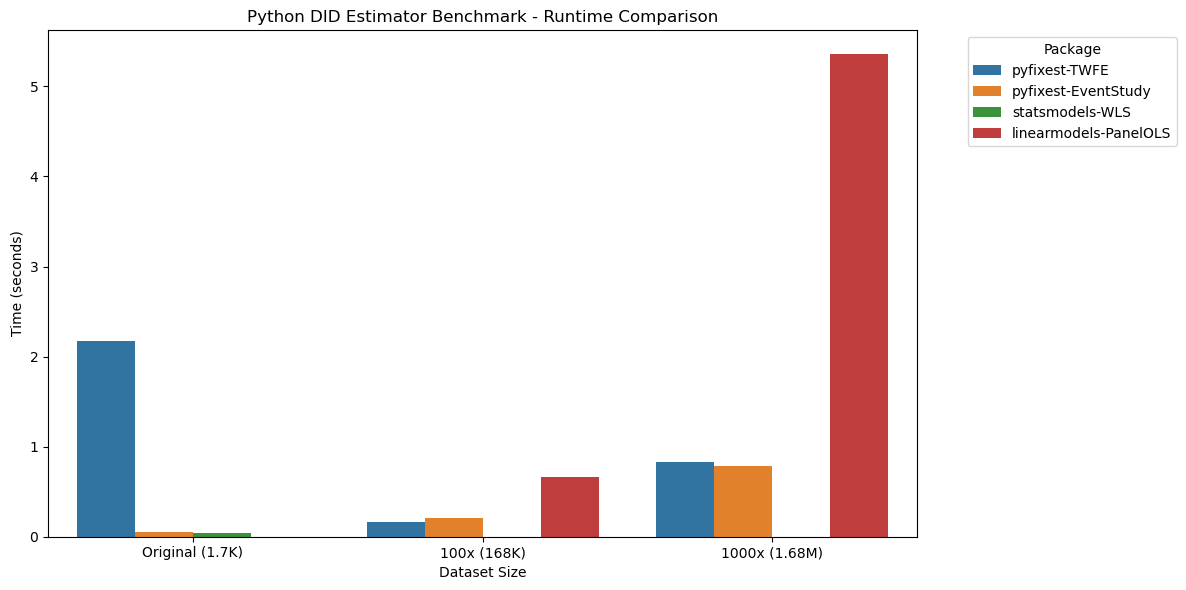


Visualization saved to: benchmark_python_results.png


In [24]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))

# Filter completed results
plot_df = results_df[results_df['status'] == 'completed'].copy()

if len(plot_df) > 0:
    sns.barplot(data=plot_df, x='scenario', y='time_seconds', hue='package', ax=ax)
    ax.set_xlabel('Dataset Size')
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Python DID Estimator Benchmark - Runtime Comparison')
    ax.legend(title='Package', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('benchmark_python_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nVisualization saved to: benchmark_python_results.png")
else:
    print("No completed results to visualize.")